In [ ]:
from cellitaire.game.game import Game
from cellitaire.game.card import Card
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import itertools
import time
%matplotlib inline
import random
from collections import deque

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def getBoardState(board):
    return torch.tensor([[slot.card.card_id if slot.card != None else 0 for slot in row] for row in board.slots], device=device)

def getStockpileState(stockpile):
    top_card = stockpile.top_card()
    return torch.concat(
        (torch.tensor([top_card.card_id if top_card != None else 0], dtype=torch.float, device=device),
        torch.tensor([stockpile.count()], dtype=torch.float, device=device))
    )

def getFoundationState(foundation):
    return torch.tensor([Card.RANKS.index(card.rank) + 1 if card != None else 0 for suit, card in foundation.foundation.items()], dtype=torch.float, device=device)

def getFlattenedState(game):
    board_state = getBoardState(game.board)
    stockpile_state = getStockpileState(game.stockpile)
    foundation_state = getFoundationState(game.foundation)
    return torch.cat((board_state.view(1, -1), stockpile_state.view(1, -1), foundation_state.view(1, -1)), dim=1)

In [81]:
class Model:
    def __init__(self, card_emb_dim, cnn_1_out_channels, device, hidden_size, board_rows, board_cols):
        self.card_embedding_layer = torch.nn.Embedding(num_cards, card_emb_dim, device=device)
        self.board_cnn_1 = torch.nn.Conv2d(in_channels=card_emb_dim, out_channels=cnn_1_out_channels, kernel_size=3, stride=1, padding=1, device=device)
        self.hidden_layer1 = torch.nn.Linear(cnn_1_out_channels * board_rows * board_cols + 6, hidden_size, device=device)
        self.relu1 = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(hidden_size, board_rows * board_cols, device=device)
        self.board_rows = board_rows
        self.board_cols = board_cols

    '''
    
    def __call__(self, game):
        board_state = getBoardState(game.board)
        stockpile_state = getStockpileState(game.stockpile)
        foundation_state = getFoundationState(game.foundation)

        board_state_emb = self.card_embedding_layer(board_state)
        board_state_emb = board_state_emb.permute(2, 0, 1)
        
        cnn_1_otpt = self.board_cnn_1(board_state_emb)

        all_inputs = torch.cat((foundation_state.view(1, 4), stockpile_state.view(1, 2), cnn_1_otpt.view(1, -1)), dim=1)

        x = self.hidden_layer1(all_inputs)
        x = self.relu1(x)
        x = self.output_layer(x)
        self.out = x
        return x

    '''

    def __call__(self, flat_input):
        """
        Expects flat_input to be a tensor of shape 
          (batch_size, board_rows * board_cols + 6),
        where the first board_rows * board_cols values are the board card IDs,
        and the remaining 6 values are the concatenated foundation (4) and stockpile (2) features.
        """
        batch_size = flat_input.shape[0]
        
        # Extract and reshape the board part (make sure they are of type long for the embedding)
        board_flat = flat_input[:, :self.board_rows * self.board_cols].long()
        board_state = board_flat.view(batch_size, self.board_rows, self.board_cols)
        
        # The extra features (foundation and stockpile) remain as floats.
        extra_features = flat_input[:, self.board_rows * self.board_cols:]
        
        # Process the board state: embed and run through CNN
        board_state_emb = self.card_embedding_layer(board_state)  # (batch_size, board_rows, board_cols, card_emb_dim)
        board_state_emb = board_state_emb.permute(0, 3, 1, 2)        # (batch_size, card_emb_dim, board_rows, board_cols)
        cnn_1_otpt = self.board_cnn_1(board_state_emb)               # (batch_size, cnn_1_out_channels, board_rows, board_cols)
        cnn_1_otpt_flat = cnn_1_otpt.reshape(batch_size, -1)            # (batch_size, cnn_1_out_channels * board_rows * board_cols)
        
        # Concatenate extra features with the CNN output
        all_inputs = torch.cat((extra_features, cnn_1_otpt_flat), dim=1)
        
        # Forward pass through the rest of the network
        x = self.hidden_layer1(all_inputs)
        x = self.relu1(x)
        x = self.output_layer(x)
        self.out = x
        return x


    def parameters(self):
        return itertools.chain(
            self.card_embedding_layer.parameters(),
            self.board_cnn_1.parameters(),
            self.hidden_layer1.parameters(),
            self.output_layer.parameters()
        )

In [77]:
m = Model(card_emb_dim, cnn_1_out_channels, device, hidden_size, board_rows, board_cols)

g = Game()
g.new_game(board_rows, board_cols, num_reserved)
fs = getFlattenedState(g)
fs.shape
otpt = m(fs)

torch.Size([1, 7, 12, 10])
torch.Size([1, 10, 7, 12])
torch.Size([1, 3, 7, 12])


In [82]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

In [54]:
class TestingEnvironment:
    def __init__(self, card_emb_dim, cnn_1_out_channels, device, hidden_size, board_rows, board_cols, num_reserved, replay_buffer_size,
                num_episodes, batch_size, gamma, learning_rate, epsilon_start, epsilon_final, epsilon_decay, max_moves_per_episode):
        self.game = Game()
        self.prev_foundation_count = 0

        self.board_rows = board_rows
        self.board_cols = board_cols
        self.num_reserved = num_reserved

        self.model = Model(card_emb_dim, cnn_1_out_channels, device, hidden_size, board_rows, board_cols)
        self.replay_buffer = ReplayBuffer(replay_buffer_size)
        self.calculate_score_by_foundation_count()

        self.device = device

        self.num_episodes = num_episodes
        self.batch_size = batch_size
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon_start = epsilon_start
        self.epsilon_final = epsilon_final
        self.epsilon_decay = epsilon_decay
        self.max_moves_per_episode = max_moves_per_episode

        self.time_track_map = {}

        self.initialize_time_metrics('getting_moves')
        self.initialize_time_metrics('getting_action')
        self.initialize_time_metrics('stepping')
        self.initialize_time_metrics('replay')

        self.losses = []

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def reset_episode(self):
        self.game.new_game(self.board_rows, self.board_cols, self.num_reserved)

        self.prev_foundation_count = self.game.foundation.total_cards()

    def initialize_time_metrics(self, tag):
        self.time_track_map[tag + '_sum'] = 0
        self.time_track_map[tag + '_count'] = 0
    
    def print_time_metrics(self, tag):
        if self.time_track_map[tag + '_count'] > 0:
            print(
                tag + '_average:', self.time_track_map[tag + '_sum'] / self.time_track_map[tag + '_count'],
                tag + '_time:', self.time_track_map[tag + '_sum'])

    def add_time(self, tag, time):
        self.time_track_map[tag + '_count'] += 1
        self.time_track_map[tag + '_sum'] += time

    def train(self):
        frame_idx = 0

        for i in range(self.num_episodes):
            frame_idx = self.run_episode(frame_idx)
            print('------')
            self.print_time_metrics('getting_moves')
            self.print_time_metrics('getting_action')
            self.print_time_metrics('stepping')
            self.print_time_metrics('replay')

            if i % 100 == 0:
                print(len(self.losses))

    def run_episode(self, frame_idx):
        self.reset_episode()
        done = False

        move_count = 0
        while not done:
            frame_idx += 1
            epsilon = self.epsilon_by_frame(frame_idx)

            get_moves_start = time.time()
            special_coords = self.game.get_possible_lonely_suffocated_coords()
            placeable_coords = self.game.get_possible_placeable_coords()
            legal_moves = list(set(special_coords + placeable_coords))
            get_moves_end = time.time()
            self.add_time('getting_moves', get_moves_end - get_moves_start)

            if random.random() < epsilon:
                action = random.choice(legal_moves)
            else:
                get_action_start = time.time()
                q = self.model(getFlattenedState(self.game))
                action = self.get_action(q, legal_moves)
                get_action_end = time.time()
                self.add_time('getting_action', get_action_end - get_action_start)

            step_start = time.time()
            current_state, next_state, done, reward = self.step(action)
            step_end = time.time()
            self.add_time('stepping', step_end - step_start)
            
            self.replay_buffer.push(current_state, action, reward, next_state, done)
            if len(self.replay_buffer) > self.batch_size:
                replay_start = time.time()
                self.replay()
                replay_end = time.time()
                self.add_time('replay', replay_end - replay_start)
            move_count += 1
            if move_count >= self.max_moves_per_episode:
                break
        return frame_idx
    '''

    def replay(self):
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        rewards_tensor = torch.tensor(rewards, device=self.device)
        dones_tensor = torch.tensor(dones, dtype=torch.int, device=self.device)

        current_qs = torch.tensor([], device=self.device)
        next_qs = torch.tensor([], device=self.device)
        for state in states:
            current_qs = torch.cat((current_qs, self.model(state)))
        with torch.no_grad():
            for state in next_states:
                next_qs = torch.cat((next_qs, self.model(state)))
            next_qs_max, _ = next_qs.max(dim=1)
            target = rewards_tensor + self.gamma * next_qs_max * (1 - dones_tensor)
        loss = nn.MSELoss()(current_qs, target.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.losses.append(loss.item())

    '''

    def replay(self):
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        rewards_tensor = torch.tensor(rewards, device=self.device)
        dones_tensor = torch.tensor(dones, dtype=torch.int, device=self.device)
    
        # Assuming states and next_states can be converted to tensors:
        # If needed, preprocess or convert state objects to tensors here.
        state_batch = torch.stack(states)       # Now shape is (batch_size, ...)
        next_state_batch = torch.stack(next_states)
    
        # Get current Q-values for all states in one forward pass.
        current_qs = self.model(state_batch)
        
        # Get next Q-values in one forward pass.
        with torch.no_grad():
            next_qs = self.model(next_state_batch)
            next_qs_max, _ = next_qs.max(dim=1)
            target = rewards_tensor + self.gamma * next_qs_max * (1 - dones_tensor)
        
        loss = nn.MSELoss()(current_qs, target.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.losses.append(loss.item())


    def step(self, action):
        current_state = getFlattenedState(self.game)
        self.game.make_move(action)
        done, reward = self.compute_step_components()
        next_state = getFlattenedState(self.game)
        return current_state, next_state, done, reward

    def get_action(self, network_output, legal_moves):
        legal_moves_as_otpt_idx = [r * self.board_cols + c for r, c in legal_moves]
        moves_with_mask = torch.full_like(network_output, -1e9)
        for idx in legal_moves_as_otpt_idx:
            moves_with_mask[0, idx] = 0
        with torch.no_grad():
            moves_with_mask = moves_with_mask + network_output
        move_idx = torch.max(moves_with_mask, 1).indices[0]
        move_row = move_idx // self.board_cols
        move_col = move_idx % self.board_cols
        return (move_row.item(), move_col.item())
            
    def compute_step_components(self):
        done = not self.game.possible_moves_remaining()

        current_foundation_count = self.game.foundation.total_cards()

        if done:
            self.prev_foundation_count = current_foundation_count
            return done, self.get_score_from_foundation_count(current_foundation_count)

        reward = 0
        if current_foundation_count > self.prev_foundation_count:
            reward = 0.1

        self.prev_foundation_count = current_foundation_count

        return done, reward

    def epsilon_by_frame(self, frame_idx):
        return self.epsilon_final + (self.epsilon_start - epsilon_final) * math.exp(-1.0 * frame_idx / epsilon_decay)

    def get_score_from_foundation_count(self, foundation_count):
        if foundation_count < 40:
            return -1
        return self.foundation_count_to_score[foundation_count]

    def calculate_score_by_foundation_count(self):
        self.foundation_count_to_score = {foundation_count: ((foundation_count - 40.0) / 12.0) ** (math.log(0.5) / math.log(5.0 / 6.0)) for foundation_count in range(40, 53)}
            
        

In [144]:
class TestingEnvironment:
    def __init__(self, card_emb_dim, cnn_1_out_channels, device, hidden_size, board_rows, board_cols, num_reserved, replay_buffer_size,
                 num_episodes, batch_size, gamma, learning_rate, epsilon_start, epsilon_final, epsilon_decay, max_moves_per_episode):
        self.game = Game()
        self.prev_foundation_count = 0

        self.board_rows = board_rows
        self.board_cols = board_cols
        self.num_reserved = num_reserved

        self.model = Model(card_emb_dim, cnn_1_out_channels, device, hidden_size, board_rows, board_cols)
        self.replay_buffer = ReplayBuffer(replay_buffer_size)
        self.calculate_score_by_foundation_count()

        self.device = device

        self.num_episodes = num_episodes
        self.batch_size = batch_size
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon_start = epsilon_start
        self.epsilon_final = epsilon_final
        self.epsilon_decay = epsilon_decay
        self.max_moves_per_episode = max_moves_per_episode

        self.time_track_map = {}
        self.initialize_time_metrics('getting_moves')
        self.initialize_time_metrics('getting_action')
        self.initialize_time_metrics('stepping')
        self.initialize_time_metrics('replay')

        self.losses = []
        self.cards_saved = []
        self.illegal_move_count = 0
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def reset_episode(self):
        self.game.new_game(self.board_rows, self.board_cols, self.num_reserved)
        self.prev_foundation_count = self.game.foundation.total_cards()

    def initialize_time_metrics(self, tag):
        self.time_track_map[tag + '_sum'] = 0
        self.time_track_map[tag + '_count'] = 0
    
    def print_time_metrics(self, tag):
        if self.time_track_map[tag + '_count'] > 0:
            print(
                tag + '_average:', self.time_track_map[tag + '_sum'] / self.time_track_map[tag + '_count'],
                tag + '_time:', self.time_track_map[tag + '_sum'])

    def add_time(self, tag, t):
        self.time_track_map[tag + '_count'] += 1
        self.time_track_map[tag + '_sum'] += t

    def print_all_time_metrics(self):
        print('------')
        self.print_time_metrics('getting_moves')
        self.print_time_metrics('getting_action')
        self.print_time_metrics('stepping')
        self.print_time_metrics('replay')

    def train(self):
        frame_idx = 0
        for i in range(self.num_episodes):
            frame_idx = self.run_episode(frame_idx)
            if i % 100 == 0 and len(self.losses) > 0:
                print("average loss:", sum(self.losses[-100:]) / len(self.losses[-100:]))
                print("average cards saved:", sum(self.cards_saved[-100:]) / len(self.cards_saved[-100:]))
                print("max cards saved:", max(self.cards_saved[-100:]))
                print("percentage of games ended in illegal move:", (self.illegal_move_count / (i + 1)) * 100)

    def run_episode(self, frame_idx):
        self.reset_episode()
        done = False
        move_count = 0
        while not done:
            frame_idx += 1
            epsilon = self.epsilon_by_frame(frame_idx)

            get_moves_start = time.time()
            special_coords = self.game.get_possible_lonely_suffocated_coords()
            placeable_coords = self.game.get_possible_placeable_coords()
            legal_moves = list(set(special_coords + placeable_coords))
            get_moves_end = time.time()
            self.add_time('getting_moves', get_moves_end - get_moves_start)

            if random.random() < epsilon:
                action = random.choice(legal_moves)
            else:
                get_action_start = time.time()
                # Use the flattened state representation here
                state_flat = getFlattenedState(self.game)
                q = self.model(state_flat)
                action = self.get_action(q, legal_moves)
                get_action_end = time.time()
                self.add_time('getting_action', get_action_end - get_action_start)

            step_start = time.time()
            current_state, next_state, done, reward = self.step(action)
            step_end = time.time()
            self.add_time('stepping', step_end - step_start)
            
            # Push the flattened state tensors into the replay buffer
            self.replay_buffer.push(current_state, action, reward, next_state, done)
            
            if len(self.replay_buffer) > self.batch_size:
                replay_start = time.time()
                self.replay()
                replay_end = time.time()
                self.add_time('replay', replay_end - replay_start)
                
            move_count += 1
            if move_count >= self.max_moves_per_episode:
                break
        self.cards_saved.append(self.game.foundation.total_cards())
        return frame_idx

    def replay(self):
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        rewards_tensor = torch.tensor(rewards, device=self.device)
        dones_tensor = torch.tensor(dones, dtype=torch.int, device=self.device)
        
        # Each state is already flattened (shape: (1, flat_dim)); stack them into a batch
        state_batch = torch.cat(states, dim=0)
        next_state_batch = torch.cat(next_states, dim=0)
        
        current_qs = self.model(state_batch)  # shape: [batch_size, num_actions]
        actions_tensor = torch.tensor(actions, device=self.device).unsqueeze(1)  # shape: [batch_size, 1]
        current_q_for_actions = current_qs.gather(1, actions_tensor).squeeze(1)

        with torch.no_grad():
            next_qs = self.model(next_state_batch)
            next_qs_max, _ = next_qs.max(dim=1)
            target = rewards_tensor + self.gamma * next_qs_max * (1 - dones_tensor)
        
        loss = nn.MSELoss()(current_q_for_actions, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.losses.append(loss.item())

    def step(self, action):
        # Get the current flattened state before taking the action
        current_state = getFlattenedState(self.game)
        move_made = self.game.make_move(action)
        done, reward = self.compute_step_components(move_made)
        # Get the next flattened state after the move
        next_state = getFlattenedState(self.game)
        return current_state, next_state, done, reward

    def get_action(self, network_output, legal_moves):
        #legal_moves_as_otpt_idx = [r * self.board_cols + c for r, c in legal_moves]
        #moves_with_mask = torch.full_like(network_output, -1e9)
        #for idx in legal_moves_as_otpt_idx:
        #    moves_with_mask[0, idx] = 0
        #with torch.no_grad():
        #    moves_with_mask = moves_with_mask + network_output
        #move_idx = torch.max(moves_with_mask, 1).indices[0]
        move_idx = torch.max(network_output, 1).indices[0]
        move_row = move_idx // self.board_cols
        move_col = move_idx % self.board_cols
        return (move_row.item(), move_col.item())
            
    def compute_step_components(self, move_made):
        if not move_made:
            self.illegal_move_count += 1
            done = True
            reward = -1
            return done, reward
        done = not self.game.possible_moves_remaining()
        current_foundation_count = self.game.foundation.total_cards()
        if done:
            self.prev_foundation_count = current_foundation_count
            return done, self.get_score_from_foundation_count(current_foundation_count)
        reward = -0.1
        if current_foundation_count > self.prev_foundation_count:
            reward = 0.1
        self.prev_foundation_count = current_foundation_count
        return done, reward

    def epsilon_by_frame(self, frame_idx):
        return self.epsilon_final + (self.epsilon_start - self.epsilon_final) * math.exp(-1.0 * frame_idx / self.epsilon_decay)

    def get_score_from_foundation_count(self, foundation_count):
        if foundation_count < 40:
            return -1
        return self.foundation_count_to_score[foundation_count]

    def calculate_score_by_foundation_count(self):
        self.foundation_count_to_score = {foundation_count: ((foundation_count - 40.0) / 12.0) ** (math.log(0.5) / math.log(5.0 / 6.0)) for foundation_count in range(40, 53)}


In [145]:
board_rows = 7
board_cols = 12
num_reserved = 6
num_cards = 53
card_emb_dim = 30
cnn_1_out_channels = 12
hidden_size = 30
replay_buffer_size = 10000
num_episodes = 10000       
batch_size = 1000        
gamma = 0.99              
learning_rate = 1e-1
epsilon_start = 1.0
epsilon_final = 0.1
epsilon_decay = 50000
max_moves_per_episode = 300

env = TestingEnvironment(card_emb_dim, cnn_1_out_channels, device, hidden_size, board_rows, board_cols, num_reserved, replay_buffer_size, num_episodes, batch_size, gamma, learning_rate, epsilon_start, epsilon_final, epsilon_decay, max_moves_per_episode)
env.train()

RuntimeError: Index tensor must have the same number of dimensions as input tensor

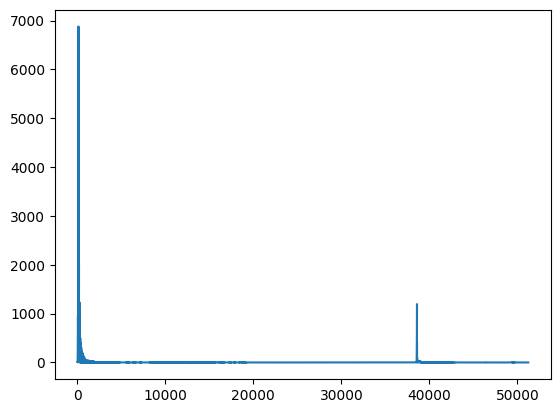

In [116]:
plt.plot(env.losses)

In [117]:
def getNumPossibleMoves(game):
    special_coords = game.get_possible_lonely_suffocated_coords()
    placeable_coords = game.get_possible_placeable_coords()
    return len(set(special_coords + placeable_coords))

In [130]:
test_game = Game()
test_game.new_game(board_rows, board_cols, num_reserved)

num_moves = 0
while getNumPossibleMoves(test_game) > 0:
    network_output = env.model(getFlattenedState(test_game))
    special_coords = test_game.get_possible_lonely_suffocated_coords()
    placeable_coords = test_game.get_possible_placeable_coords()
    legal_moves = list(set(special_coords + placeable_coords))
    legal_moves_as_otpt_idx = [r * board_cols + c for r, c in legal_moves]
    moves_with_mask = torch.full_like(network_output, -1e9)
    for idx in legal_moves_as_otpt_idx:
        moves_with_mask[0, idx] = 0
    with torch.no_grad():
        moves_with_mask = moves_with_mask + network_output
    move_idx = torch.max(moves_with_mask, 1).indices[0]
    move_row = move_idx // board_cols
    move_col = move_idx % board_cols
    test_game.make_move((move_row.item(), move_col.item()))
    num_moves += 1
    if num_moves % 10 == 0:
        print(num_moves, test_game.foundation.total_cards())
    if num_moves > 1000:
        break

saved = test_game.foundation.total_cards()
print(num_moves, saved)

10 0
20 0
30 0
32 0
